#### Import calls

In [816]:
import distutils.util
import os

%env MUJOCO_GL=glfw
%env PYOPENGL_PLATFORM=glx
%env LIBGL_ALWAYS_SOFTWARE=0

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import mujoco.viewer
import time
import itertools
import numpy as np

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)
import pygments
print_style = 'lovelace'

from IPython.display import clear_output, Audio, HTML, display
clear_output()

# import from other python files
from pend_utils import pd_control
# from cane_builder import CaneEditor

from simple_pid import PID

BROWN = np.array([0.4, 0.24, 0.0, 1])



In [818]:
class CaneEditor():
    def __init__(self, xml_name):
        self.spec = mujoco.MjSpec.from_string(xml_name)
        self.model = self.spec.compile()

    def build_branch(self, total_length, num_segments=2, radius=0.006, def_stiff=295):

        segment_length = total_length/num_segments
        self.spec.default.geom.type = mujoco.mjtGeom.mjGEOM_CYLINDER
        self.spec.default.geom.density = 550
        # main.geom.size = [radius, segment_length]
        self.spec.default.geom.solref = [0.1, 1]
        self.spec.default.geom.solimp = [0.95, 1, 0.0025, 1, 0.5]
        self.spec.default.geom.friction = [0, 0, 0]

        # joint defaults
        self.spec.default.joint.type = mujoco.mjtJoint.mjJNT_HINGE
        self.spec.default.joint.axis = [0, 1, 0]
        self.spec.default.joint.stiffness = def_stiff
        self.spec.default.joint.springref = 0
        self.spec.default.joint.damping = 0.15

        self.spec.default.site.type =mujoco.mjtGeom.mjGEOM_SPHERE
        self.spec.default.site.size = np.array([0.01, 0.01, 0.01])
        self.spec.default.site.rgba = np.array([0, 0, 0, 1])

        base_body = None
        for body in self.spec.bodies:
            if body.name == "branch_base":
                base_body = body
                break
        if base_body is None:
            raise ValueError("Branch base body not found in the model.")
        
        parent_body = base_body
        for i in range(num_segments):
            body_name = f"branch_body_{i}"
            joint_name = f"branch_joint_{i}"
            segment_geom_name = f"branch_geom{i}"
            site_name = f"joint_site{i}"

            # Generate a random RGBA color for the segment
            rgba = np.random.uniform(size=4)
            rgba[3] = 1
            brown_variant = (rgba + BROWN*2) / 3

            # add child body to parent
            if parent_body == base_body:
                # start the first segment at the base
                child_body = parent_body.add_body(name=body_name, 
                                              pos=[0,0,0])
            else:
                # start the subsequent segments at the end of the previous segment
                child_body = parent_body.add_body(name=body_name, 
                                                  pos=[0,0,segment_length])
            # print(f"Adding body: {child_body.name} at position: {child_body.pos}")
            # add hinge to child body
            child_body.add_joint(name=joint_name)
            child_body.add_site(name=site_name)    
            # add geometry to child body
            child_body.add_geom(name=segment_geom_name,
                                 pos=[0, 0, segment_length/2], 
                                 type=mujoco.mjtGeom.mjGEOM_BOX,
                                 size=[radius, radius, segment_length/2],
                                 rgba=brown_variant)
            parent_body = child_body

        # self.spec.keyframe.add_key(name="initial", qpos=np.zeros(self.model.nq), qvel=np.zeros(self.model.nv))
        self.model = self.spec.compile()

    def show_camera_position(self, cam_id=0):
        with mujoco.Renderer(self.model) as renderer:
            cam = renderer.scene.camera[cam_id]
            print(f"Camera position: {cam.pos}")


    def show_new_model(self):
        self.model = self.spec.compile()
        data = mujoco.MjData(self.model)
        with mujoco.Renderer(self.model) as renderer:
            mujoco.mj_forward(self.model, data)
            renderer.update_scene(data)
            media.show_image(renderer.render())

    def print_xml(self):
        formatter = pygments.formatters.HtmlFormatter(style=print_style)
        lexer = pygments.lexers.XmlLexer()
        highlighted = pygments.highlight(self.spec.to_xml(), lexer, formatter)
        display(HTML(f"<style>{formatter.get_style_defs()}</style>{highlighted}"))

#### Let's build the tree!

Let's show the initial MJDF:

""

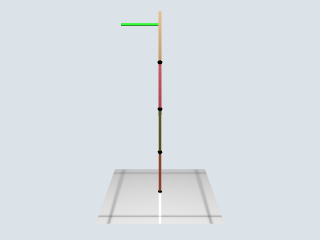

[0. 0. 0.]


In [819]:
with open('../urdf/branch_base.xml', 'r') as f:
  branch_xml = f.read()

BRANCH_STIFFNESS = 295
NUM_SEGMENTS = 4
editor = CaneEditor(branch_xml)
editor.build_branch(total_length=0.8, num_segments=NUM_SEGMENTS, radius=0.006, def_stiff=BRANCH_STIFFNESS)
editor.show_new_model()
k_equiv = 1/((1/BRANCH_STIFFNESS) * NUM_SEGMENTS)

model = editor.model
print(model.body_inertia[model.body("branch_body_0").id])

# Display the edited XML
# editor.print_xml()

In [820]:
# model = mujoco.MjModel.from_xml_string(hand_model)
data = mujoco.MjData(model)

model.opt.timestep = .00001

DURATION = 5
framerate = 60
CTRL_POS = 0.001 # 1 mm
CTRL_POS_UPDATE_RATE = 1 # s

# Kp = np.array([295])
# Kd = np.array([.15])
init_angles = np.zeros(model.njnt)

timevals = []
posvals = []
velvals = []
forcevals = []
contact_x_forces = []

# pre-inertia correction
# KU=375
# TU=0.103
# pid = PID(Kp=KU*.45, Ki=200, Kd=1*KU*TU, setpoint=CTRL_POS, output_limits=(-10, 50))

KU = 625
TU = 0.095
pid = PID(Kp=KU*.5, Ki=55, Kd=3*KU*TU, setpoint=CTRL_POS, output_limits=(-10, 50))
# pid = PID(Kp=62.5, Ki=15, Kd=6*KU*TU, setpoint=CTRL_POS, output_limits=(-10, 50))

frames = []
# mujoco.mj_resetDataKeyframe(model, data, 0)
with mujoco.Renderer(model, width=640, height=480) as renderer:
  time_since_last_ctrl_update = 0.0
  while data.time < DURATION:
    if time_since_last_ctrl_update >= CTRL_POS_UPDATE_RATE:
      time_since_last_ctrl_update = 0.0
      CTRL_POS += 0.001
      pid.setpoint = CTRL_POS
      print(f"Time is now {data.time:.3f} s, setting control position to {CTRL_POS:.3f} m")

    # control loop
    current_position = data.qpos[0]
    ctrl_force = k_equiv*data.qpos[0]+pid(current_position) # relying on sin(theta) appx = theta for small angles
    # ctrl_force = pid(current_position)
    data.ctrl[0] = ctrl_force

    # step the simulation 

    # update the values 
    mujoco.mj_step(model, data)
    timevals.append(data.time)
    posvals.append(data.qpos.copy())
    velvals.append(data.qvel.copy())
    forcevals.append(data.actuator_force.copy())

    # --- Isolate x-aligned contact force between probe and branch ---
    x_force = 0.0
    if data.ncon > 0:
      for i in range(data.ncon):
          contact = data.contact[i]
          # Get the body IDs for the two geoms in contact
          body1_id = model.geom_bodyid[contact.geom1]
          body2_id = model.geom_bodyid[contact.geom2]
          # Get the body names
          body1 = model.body(body1_id).name
          body2 = model.body(body2_id).name
          # Check if this contact includes the probe_link
          if "probe_link" in [body1, body2]:
              # Get the contact force (6D: [fx, fy, fz, tx, ty, tz])
              force = np.zeros(6)
              mujoco.mj_contactForce(model, data, i, force)
              # Rotate the force into the world frame from the contact frame
              R = np.array(contact.frame).reshape(3,3)
              force_world = R @ force[:3]
              # Add the x-component (force[0]) in the contact frame
              x_force += force_world[0]
      contact_x_forces.append(x_force)
    else:
      contact_x_forces.append(0.0)
    # --------------------------------------------------------------
    if len(frames) < data.time*framerate:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames.append(pixels)
    time_since_last_ctrl_update += model.opt.timestep

media.show_video(frames, fps=framerate)
  

Time is now 1.000 s, setting control position to 0.002 m
Time is now 2.000 s, setting control position to 0.003 m
Time is now 3.000 s, setting control position to 0.004 m
Time is now 4.000 s, setting control position to 0.005 m


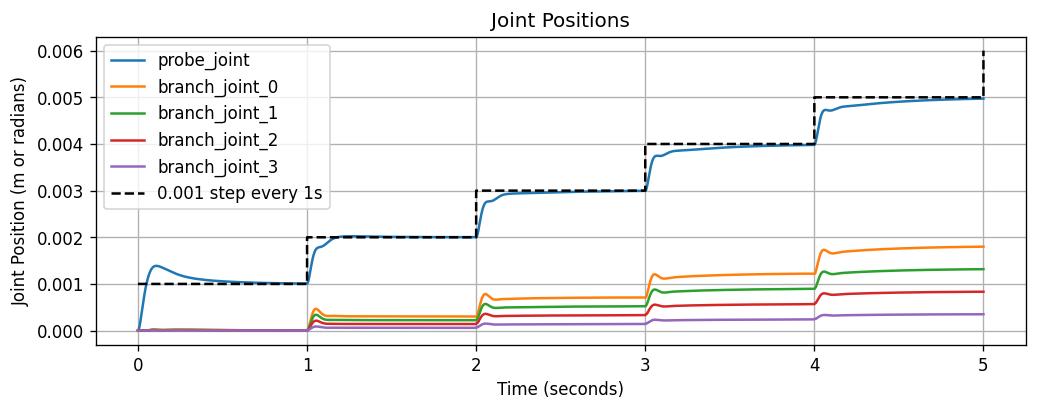

In [821]:
dpi = 120
width = 1200
height = 400
figsize = (width/dpi, height/dpi)
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

pos_array = np.array(posvals)  # shape: (timesteps, njnt)
  # shape: (timesteps, njnt)
for j in range(model.njnt):
    # Get joint name using the MuJoCo API
    joint_name = model.joint(j).name
    ax.plot(timevals, pos_array[:, j], label=joint_name)


ax.set_title("Joint Positions")
ax.set_ylabel("Joint Position (m or radians)")
ax.set_xlabel("Time (seconds)")

# Add a reference line that steps up by 0.001 every 1 second
step_height = 0.001
step_interval = 1.0
step_times = np.arange(0, timevals[-1]+step_interval, step_interval)
step_values = np.arange(0, step_height*len(step_times), step_height)
# Interpolate to match the timevals for plotting as a step function
step_ref = np.zeros_like(timevals)
for i, t in enumerate(timevals):
    idx = np.searchsorted(step_times, t, side='right')
    step_ref[i] = step_values[idx] if idx < len(step_values) else step_values[-1]
ax.step(timevals, step_ref, where='post', linestyle='--', color='black', label='0.001 step every 1s')
ax.legend()
ax.grid(True)

# filename = f"../images/plots/joint_positions_kv{int(model.actuator(0).gainprm[0])}_dt{model.opt.timestep}.png"
# fig.savefig(filename)

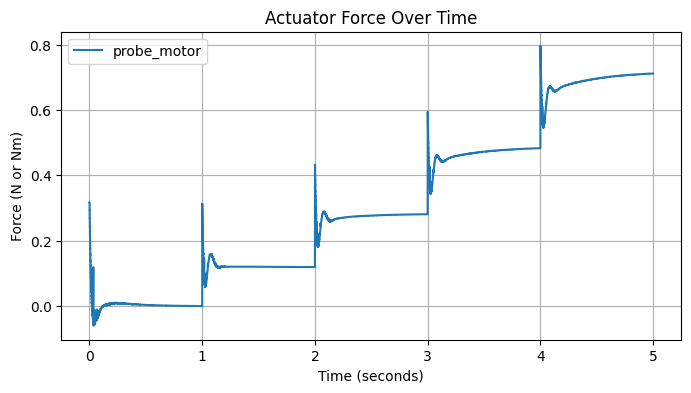

In [822]:
force_array = np.array(forcevals)  # shape: (timesteps, n_actuator)
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(model.nu):
    actuator_name = model.actuator(i).name
    ax.plot(timevals, force_array[:, i], label=actuator_name)
ax.set_title("Actuator Force Over Time")
ax.set_ylabel("Force (N or Nm)")
ax.set_xlabel("Time (seconds)")
ax.legend()
ax.grid(True)

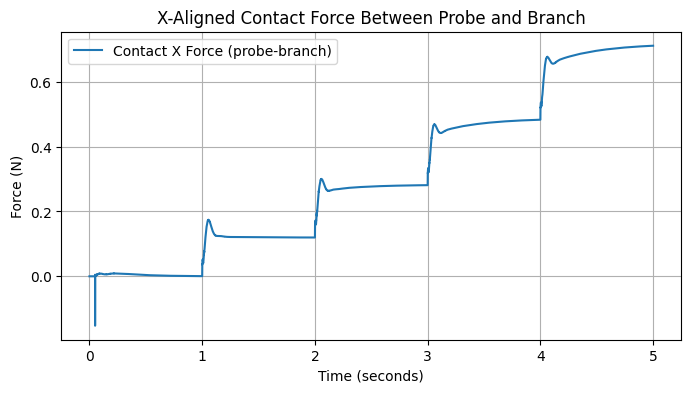

In [823]:
# Plot x-aligned contact force between probe and branch over time
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(timevals, contact_x_forces, label="Contact X Force (probe-branch)")
ax.set_title("X-Aligned Contact Force Between Probe and Branch")
ax.set_ylabel("Force (N)")
ax.set_xlabel("Time (seconds)")
ax.legend()
ax.grid(True)

# filename = f"../images/plots/x_force_kv{int(model.actuator(0).gainprm[0])}_dt{model.opt.timestep}.png"
# fig.savefig(filename)

In [824]:
PROBE_HEIGHT = 0.75  # height of probe above branch in meters
branch_max_disp = pos_array[-1, 0] # branch displacement at the end of the run
print(f"Final branch displacement: {branch_max_disp:.3f} rad")
napkin_math_force = (295* branch_max_disp)/PROBE_HEIGHT
# napkin_math_force = (295* branch_max_disp + .15*branch_max_vel)/.75
print(f"Napkin math force: {napkin_math_force:.3f} N")
print(f"Final contact x force: {contact_x_forces[-1]:.3f} N")
print("Last actuator force:", forcevals[-1])

os.system('aplay /usr/share/sounds/sound-icons/cembalo-1.wav &')

print(f"Last probe position: {data.qpos[0]:.6f} m")

Final branch displacement: 0.005 rad
Napkin math force: 1.956 N
Final contact x force: 0.711 N
Last actuator force: [0.711]
Last probe position: 0.004972 m


Playing WAVE '/usr/share/sounds/sound-icons/cembalo-1.wav' : Signed 16 bit Little Endian, Rate 16000 Hz, Mono


      <geom size="0.01 0.01 0.01" pos="0.1 0 0" type="box" rgba="1 0 0 1"/>
      <geom size="0.005 0.0175" pos="0.0975 0 0" quat="0.707107 0.707106 0 0" type="cylinder" rgba="1 0 0 1"/>
      <geom size="0.005 0.025" pos="0.1225 0.0175 0" quat="0.704433 -0.0614407 0.704432 0.0614408" type="cylinder" rgba="1 0 0 1"/>
      <geom size="0.005 0.025" pos="0.1225 -0.0175 0" quat="0.704433 0.0614407 0.704432 -0.0614408" type="cylinder" rgba="1 0 0 1"/>